## This is my code example about a simple approach of data prediction with PyTorch

#### Load python packages for this task

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn 
from sklearn.preprocessing import MinMaxScaler


#### open csv file in the folder with .ipynb file

In [2]:
data = pd.read_csv('pv_yield_month.csv', sep=";") # read the data as pandas dataframe

 #### show data to get an idea about the time series (every month a time step from 2014 - 2020)

In [3]:
data

,year,month,yield_kWh
0,2014,January,152
1,2014,Fabruary,279
2,2014,March,420
3,2014,April,570
4,2014,May,659
...,...,...,...
79,2020,August,647
80,2020,September,562
81,2020,October,266
82,2020,November,291


In [4]:
data.info() # general info about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   year       84 non-null     int64 
 1   month      84 non-null     object
 2   yield_kWh  84 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ KB


In [5]:
## Data set looks fine, no missing Data or null data and equal datatypes
## We have 84 month of data representing 7 years

#### Nevertheless we want to change the yield type to float in a single list to "extract" the important part

In [6]:
yield_data = data["yield_kWh"].values.astype(float)
yield_data

array([152., 279., 420., 570., 659., 761., 700., 570., 518., 392., 244.,
        76., 141., 316., 452., 733., 752., 819., 742., 670., 493., 331.,
       228., 212., 175., 259., 433., 580., 691., 626., 746., 715., 642.,
       333., 210., 245., 233., 234., 524., 604., 719., 786., 687., 598.,
       474., 331., 176.,  47., 138., 370., 405., 654., 787., 697., 834.,
       738., 567., 405., 263., 141.,  92., 215., 160., 674., 665., 822.,
       732., 679., 509., 308., 217., 164., 206., 237., 540., 819., 874.,
       727., 728., 647., 562., 266., 291., 133.])

#### Let's plot the data to see how it looks like

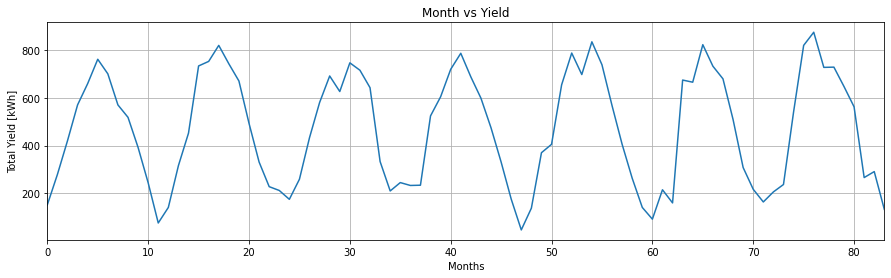

In [7]:
# change the figure's size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

# plot the figure
plt.title('Month vs Yield')
plt.ylabel('Total Yield [kWh]')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['yield_kWh'])


### data processing as preparation

#### Let's see if we can "predict" the last year (12 month) from the data of the 72 month before

In [8]:
# devide the data set into training and test set
test_data_size = 12
train_data = yield_data[:-test_data_size]  # training set for the LSTM algorith
test_data = yield_data[-test_data_size:]  # to evaluate the the performace of the test set


In [9]:
# quick check
print(len(test_data))
print(len(train_data))
print((test_data))
print((train_data))

12
72
[206. 237. 540. 819. 874. 727. 728. 647. 562. 266. 291. 133.]
[152. 279. 420. 570. 659. 761. 700. 570. 518. 392. 244.  76. 141. 316.
 452. 733. 752. 819. 742. 670. 493. 331. 228. 212. 175. 259. 433. 580.
 691. 626. 746. 715. 642. 333. 210. 245. 233. 234. 524. 604. 719. 786.
 687. 598. 474. 331. 176.  47. 138. 370. 405. 654. 787. 697. 834. 738.
 567. 405. 263. 141.  92. 215. 160. 674. 665. 822. 732. 679. 509. 308.
 217. 164.]


#### Data normalization for the time series prediction

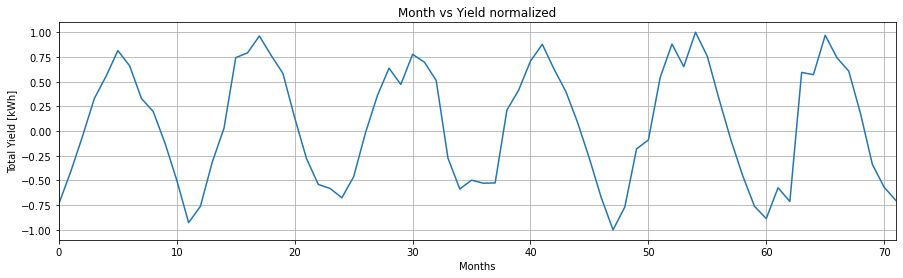

In [10]:
## use minMaxScalar from sklearn.preprocessing to transform features by scaling each feature to a given range
scaler = MinMaxScaler(feature_range=(-1, 1)) # set the range of the MinMaxScaler
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1)) #  normalization is not proceeded for the test set for not loosing any information

# how does it look like
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Yield normalized')
plt.ylabel('Total Yield [kWh]')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(train_data_normalized)

#### convert Data set into tensors

In [11]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1) # use the Float tensor, as the data is saved a float

#### convert our training data into sequences and corresponding labels

In [12]:
## sequence of 12 is useful here as we want to predict 1 year
## this depends on the given data

train_window = 12

In [13]:
## we need tuples for the sequences 
## write a funktion to transform the data 

## function accept the raw input data and returns a list of tuples
## In each tuple, the first element will contain a list of 12 items corresponding to the yield in 12 months
## the second tuple element will contain one item i.e. the yield in the 12+1st month.

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)  # total length of the data 
    for i in range(L-tw):
        train_seq = input_data[i:i+tw] # set sequences 
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [14]:
# create the sequence + label with the function
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
## the first item is a list of 12 elements and the second is one element as the label

## Prepare the LSTM Model

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    

### short explanation of the parameters

* we have only one feature for the sequence (yield_kWh): input_size = 1 
* we need to set the number of neurons for the hidden layer with: hidden_layer_size=100
* we want the predict the yield for one month so we set: output_size=1

Other paramaters: 
* the model inherits form the PyTorch nn module
* lstm: create a multilayer LSTM to an input sequence
* linear: applies a linear transformation to the incoming data
* hidden_cell: contains previous hidden and cell state 

### the forward method: 
* input seq is passed first through the lstm layer
* lst_out is the the hidden and cell state at current time
* lstm is passed to the linear layer

In [16]:
model = LSTM() # creat an object 
loss_function = nn.MSELoss()  # cross entropy loss function as we use a classification 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimization algorithm because it is doing fine on most problems

#### give a summary of the model

In [17]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


### Train the Model

In [18]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        # print loss after 25 epochs
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00210427
epoch:  26 loss: 0.01359669
epoch:  51 loss: 0.00533692
epoch:  76 loss: 0.00177968
epoch: 101 loss: 0.00088258
epoch: 126 loss: 0.00000587
epoch: 149 loss: 0.0031886294


### making predictions 

In [19]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.8856416940689087, -0.5730622410774231, -0.7128335237503052, 0.5933926105499268, 0.5705209374427795, 0.9695044755935669, 0.7407878041267395, 0.6060991287231445, 0.1740787774324417, -0.3367217183113098, -0.5679796934127808, -0.7026683688163757]


#### for each iteration there are 12 items to make predictions about the first item from the test set 
#### the predicted values are appended to the test inputs 

In [20]:
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [21]:
test_inputs[fut_pred:]

[-0.6487016677856445,
 -0.5614956617355347,
 -0.15758921205997467,
 0.31793683767318726,
 0.6863689422607422,
 0.7616317868232727,
 0.7422198057174683,
 0.6505565047264099,
 0.3410033583641052,
 0.0066536953672766685,
 -0.3574604392051697,
 -0.42640626430511475]

### convert the normalized data back the actual data

In [22]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[185.23589373]
 [219.55145711]
 [378.48864505]
 [565.60814562]
 [710.58617878]
 [740.20210811]
 [732.56349355]
 [696.49398461]
 [574.68482152]
 [443.11822913]
 [299.83931717]
 [272.709135  ]]


### Let's check the prediction and plot the predicted values with the original values 

In [23]:
total_length = len(data.yield_kWh)
start_prediction = len(data.yield_kWh)-12

x = np.arange(start_prediction, total_length,1)
x

array([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

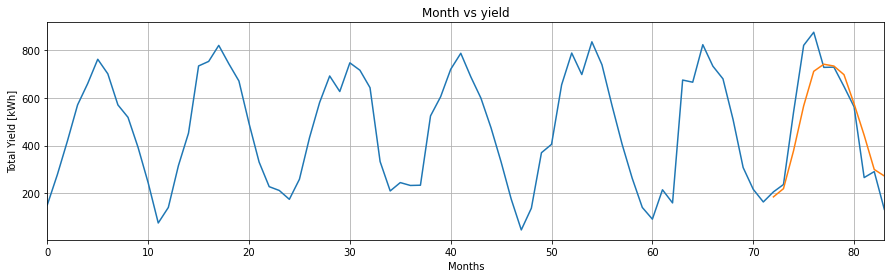

In [24]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.title('Month vs yield')
plt.ylabel('Total Yield [kWh]')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['yield_kWh'])
plt.plot(x,actual_predictions)
plt.show()

#### just show the actual year with predictions for a precise comparison

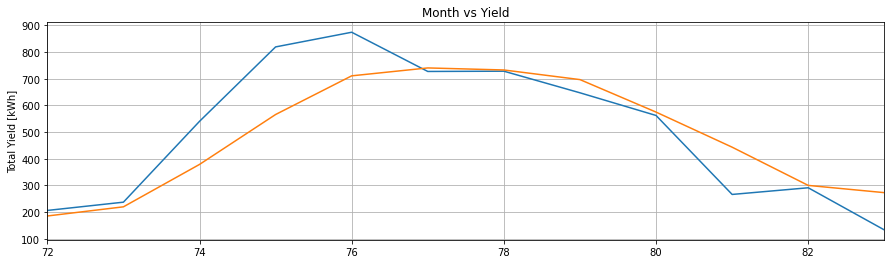

In [25]:
plt.title('Month vs Yield')
plt.ylabel('Total Yield [kWh]')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['yield_kWh'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

#### A quick check: Compare the sum of the predicted data to see the total yield for the year 


In [26]:
print(actual_predictions.sum())

5819.081409378443


In [27]:
# Compare it with the other years

ylist = np.arange(2014,2021)
yieldlist = []
for year in ylist :
    yield_per_year = data.loc[data["year"] == year, "yield_kWh"].sum()
    yieldlist.append(yield_per_year)

print(yieldlist)
print((sum(yieldlist)/len(yieldlist)))

[5341, 5889, 5655, 5413, 5999, 5237, 6030]
5652.0


## Summery and further explanations

* Focus on simplicity and easy to understand approach 
* the used data of a pv system is just an example to show the approach
* the result can variate between different predictions
* The predicted data is accurate to the normal behaviour of PV yields for this PV System
* But in general the PV yield depends on the weather --> Improve the prediction by weather data
* in 2020 the month march and april where extremely good pv month --> the model doesn't include tha*

###  Other questions for further investigation

* further exploring of the predicted data
* Check the accuracy of the model and fine tune the results 
* delivery of better results because of more training data or different model training
* Other approaches than LSTM 
* other ways to normalize the data 
* more interesting data to explore (change the data) --> e.g. daily yield in connection with consumption 
* predicition on saving of net consumption 
* ...
* Focus on the use case of the prediction!



## Thank you for your time and consideration!

### by Roman Krämer